In [ ]:
# Cài đặt các thư viện cần thiết
!pip install -U vnstock3
!pip install pmdarima
!pip install tensorflow scikit-learn
!pip install matplotlib pandas numpy statsmodels
!pip install seaborn
# Bỏ qua các cảnh báo
import os
import warnings
warnings.filterwarnings('ignore')

# Thư viện chung
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tùy chỉnh hiển thị biểu đồ
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

# LSTM và RNN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Thống kê và phân tích chuỗi thời gian (ARIMA)
from statsmodels.tsa.stattools import adfuller  # Kiểm tra độ dừng
from statsmodels.tsa.seasonal import seasonal_decompose  # Phân tích mùa vụ
from statsmodels.tsa.arima.model import ARIMA  # ARIMA model
from pmdarima.arima import auto_arima  # Tìm ARIMA tốt nhất

# Đánh giá hiệu năng mô hình
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [ ]:
from vnstock3 import Vnstock
stock_data  = Vnstock().stock(symbol='VHM', source='VCI')

2025-01-10 09:18:43 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [ ]:
df = stock_data.quote.history(start='2020-01-01', end='2024-06-21', interval='1D')
print(df.head(100))

         time   open   high    low  close   volume
0  2020-01-02  62.26  63.00  62.26  62.56   238600
1  2020-01-03  62.56  62.93  62.34  62.78   394470
2  2020-01-06  62.34  62.63  61.01  61.45  1025270
3  2020-01-07  61.16  62.49  61.16  61.75   590360
4  2020-01-08  61.16  61.53  59.69  60.79   553690
..        ...    ...    ...    ...    ...      ...
95 2020-05-26  57.11  57.40  56.30  56.30  2996560
96 2020-05-27  56.37  57.18  54.97  55.04  3769070
97 2020-05-28  55.19  56.00  54.82  55.26  4347270
98 2020-05-29  55.71  56.81  55.63  56.44  3942120
99 2020-06-01  57.03  58.58  56.96  58.29  3254070

[100 rows x 6 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    1115 non-null   datetime64[ns]
 1   open    1115 non-null   float64       
 2   high    1115 non-null   float64       
 3   low     1115 non-null   float64       
 4   close   1115 non-null   float64       
 5   volume  1115 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 52.4 KB


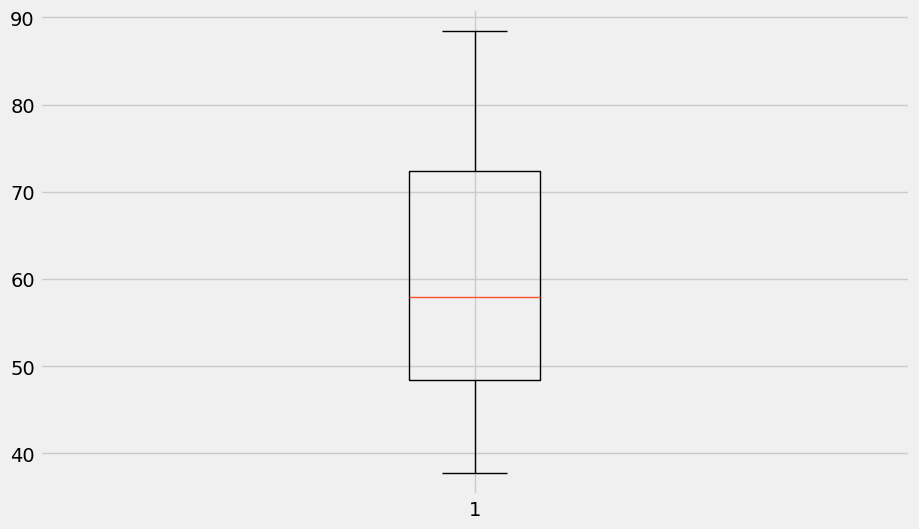

In [ ]:
data_11= df[[ 'close']]

plt.boxplot(data_11)
plt.show()

In [ ]:
# Chỉ giữ lại hai cột 'date' và 'close'
data= df[['time', 'close']]

# Đảm bảo cột 'Date' là kiểu datetime
data['time'] = pd.to_datetime(data['time'])

data.head()

,time,close
0,2020-01-02,62.56
1,2020-01-03,62.78
2,2020-01-06,61.45
3,2020-01-07,61.75
4,2020-01-08,60.79


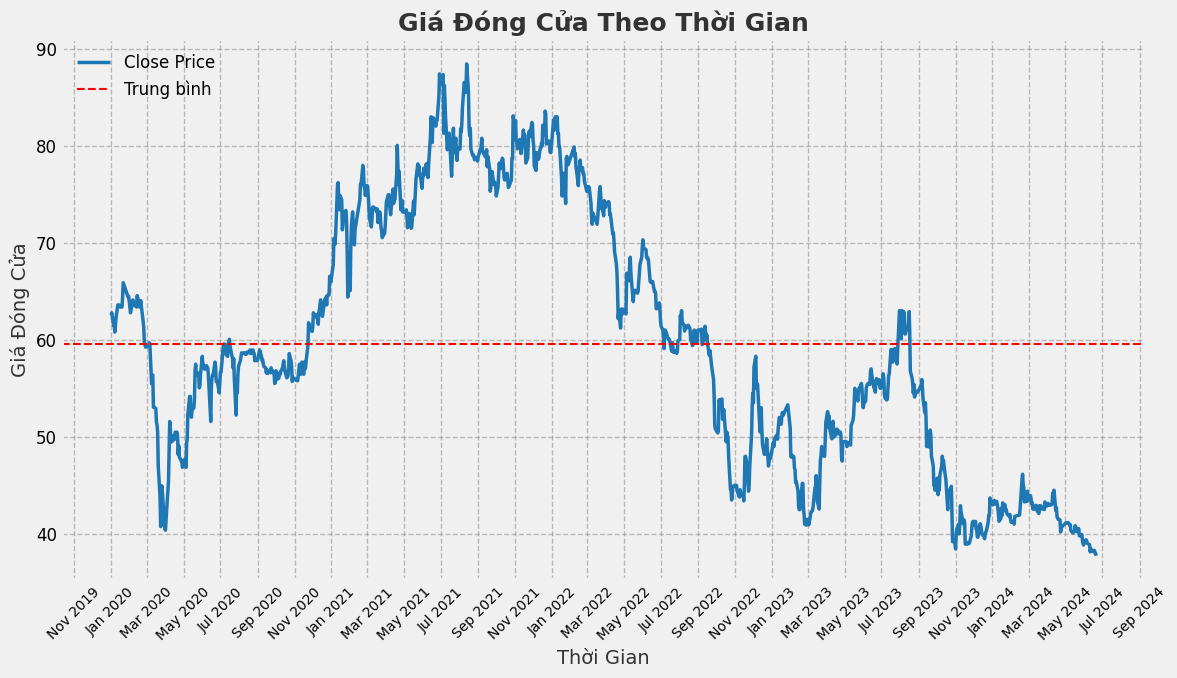

In [ ]:
import matplotlib.dates as mdates

# Tạo biểu đồ
plt.figure(figsize=(12, 7))  # Kích thước biểu đồ
plt.plot(data['time'], data['close'], label='Close Price', color='#1f77b4', linewidth=2.5)

# Tùy chỉnh trục x
if data['time'].dtype.name == 'datetime64[ns]':  # Nếu cột 'time' là dạng thời gian
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # Hiển thị 2 tháng 1 nhãn
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Hiển thị tháng và năm
    plt.xticks(rotation=45, fontsize=10)  # Xoay nhãn 45 độ, giảm kích thước font

# Tùy chỉnh trục y
plt.yticks(fontsize=12)
plt.ylabel('Giá Đóng Cửa', fontsize=14, color='#333')

# Tùy chỉnh biểu đồ
plt.title('Giá Đóng Cửa Theo Thời Gian', fontsize=18, color='#333', fontweight='bold')
plt.xlabel('Thời Gian', fontsize=14, color='#333')
plt.grid(True, linestyle='--', alpha=0.5, color='gray')
plt.axhline(y=data['close'].mean(), color='red', linestyle='--', linewidth=1.5, label='Trung bình')  # Đường trung bình
plt.legend(fontsize=12, loc='upper left', frameon=False)

# Chỉnh bố cục
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


In [ ]:
data= data[['close']]
data.head()

,close
0,62.56
1,62.78
2,61.45
3,61.75
4,60.79


In [ ]:
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu

scaler = MinMaxScaler(feature_range=(0, 1))
data= scaler.fit_transform(data)
data

array([[0.48963884],
       [0.49398066],
       [0.46773239],
       ...,
       [0.00493389],
       [0.00493389],
       [0.        ]])

In [ ]:
test_len  = 200
train_len = data.shape[0] - test_len
timesteps = 60
features  = 1

X_train = []
y_train = []

for i in range(timesteps, train_len):
  X_train.append(data[i-timesteps:i, :])
  y_train.append(data[i, :])

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

print(X_train.shape, y_train.shape)

(855, 60, 1) (855, 1)


In [ ]:
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN

# Model RNN
model_rnn = Sequential()
model_rnn.add(SimpleRNN(128, return_sequences=True, input_shape=(timesteps, features)))
model_rnn.add(SimpleRNN(128, return_sequences=False))
model_rnn.add(Dense(30))
model_rnn.add(Dense(1))

model_rnn.compile(optimizer='adam', loss='mse')

In [ ]:
return_sequences=True


In [ ]:
model_rnn.fit(X_train, y_train, batch_size=64, epochs=6)


Epoch 1/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.6542
Epoch 2/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0393
Epoch 3/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0108
Epoch 4/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0048
Epoch 5/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0032
Epoch 6/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0030


In [ ]:
X_test = []
y_test = []

for i in range(train_len, data.shape[0]):
  X_test.append(data[i-timesteps:i, :])
  y_test.append(data[i, :])

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [ ]:
# Dự đoán với model RNN
y_pred_rnn = model_rnn.predict(X_test)
y_pred_rnn = scaler.inverse_transform(y_pred_rnn)
y_test = scaler.inverse_transform(y_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [ ]:
# Tính RMSE (Root Mean Squared Error)
rmse_rnn  = np.sqrt(((y_test - y_pred_rnn) ** 2).mean())
print("RMSE:", rmse_rnn)

# Tính giá trị nhỏ nhất, lớn nhất của y_test
print("Min value of y_test:", y_test.min())
print("Max value of y_test:", y_test.max())

# Tính giá trị trung bình của y_test
mean_y_test_1 = y_test.mean()
print("Mean value of y_test:", mean_y_test_1)

# Tính tỷ lệ RMSE trên giá trị trung bình của y_test
rmse_ratio_rnn = rmse_rnn / mean_y_test_1
print("RMSE ratio:", rmse_ratio_rnn)

# Tính MAE (Mean Absolute Error)
mae_rnn  = np.mean(np.abs(y_test - y_pred_rnn))
print("MAE:", mae_rnn)


RMSE: 2.231044416294407
Min value of y_test: 37.75
Max value of y_test: 55.900000000000006
Mean value of y_test: 42.63174999999999
RMSE ratio: 0.052332930651319914
MAE: 1.8832395439147946


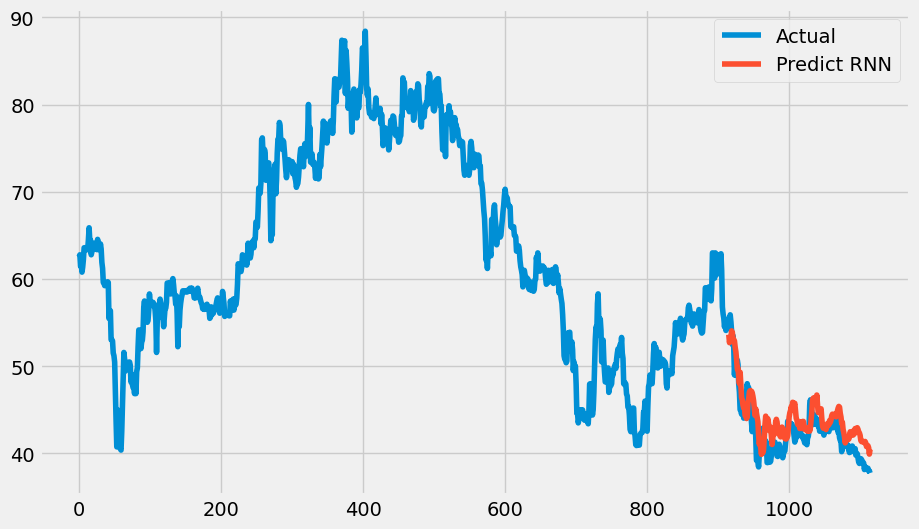

In [ ]:
actual = df[['close']]
pred_rnn = df[['close']].iloc[train_len:, :]
pred_rnn[['Predict RNN']] = y_pred_rnn
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(pred_rnn[['Predict RNN']], label='Predict RNN')
plt.legend()
plt.show()


In [ ]:
# Model LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences=True, input_shape=(timesteps, features)))
model_lstm.add(LSTM(128, return_sequences=False))
model_lstm.add(Dense(30))
model_lstm.add(Dense(1))

model_lstm.compile(optimizer='adam', loss='mse')

In [ ]:
model_lstm.fit(X_train, y_train, batch_size=64, epochs=6)


Epoch 1/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 184ms/step - loss: 0.0805
Epoch 2/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 185ms/step - loss: 0.0078
Epoch 3/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - loss: 0.0039
Epoch 4/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 0.0028
Epoch 5/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.0026
Epoch 6/6
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - loss: 0.0024


In [ ]:
# Dự đoán với model LSTM
y_pred_lstm = model_lstm.predict(X_test)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step 


In [ ]:
# Tính RMSE (Root Mean Squared Error)
rmse_lstm   = np.sqrt(((y_test - y_pred_lstm) ** 2).mean())
print("RMSE:", rmse_lstm )

# Tính giá trị nhỏ nhất, lớn nhất của y_test
print("Min value of y_test:", y_test.min())
print("Max value of y_test:", y_test.max())

# Tính giá trị trung bình của y_test
mean_y_test_1 = y_test.mean()
print("Mean value of y_test:", mean_y_test_1)

# Tính tỷ lệ RMSE trên giá trị trung bình của y_test
rmse_ratio_lstm = rmse_lstm  / mean_y_test_1
print("RMSE ratio:", rmse_ratio_lstm)

# Tính MAE (Mean Absolute Error)
mae_lstm  = np.mean(np.abs(y_test - y_pred_lstm))
print("MAE:", mae_lstm)


RMSE: 1.9557766921786242
Min value of y_test: 37.75
Max value of y_test: 55.900000000000006
Mean value of y_test: 42.63174999999999
RMSE ratio: 0.04587605932617415
MAE: 1.5133637809753417


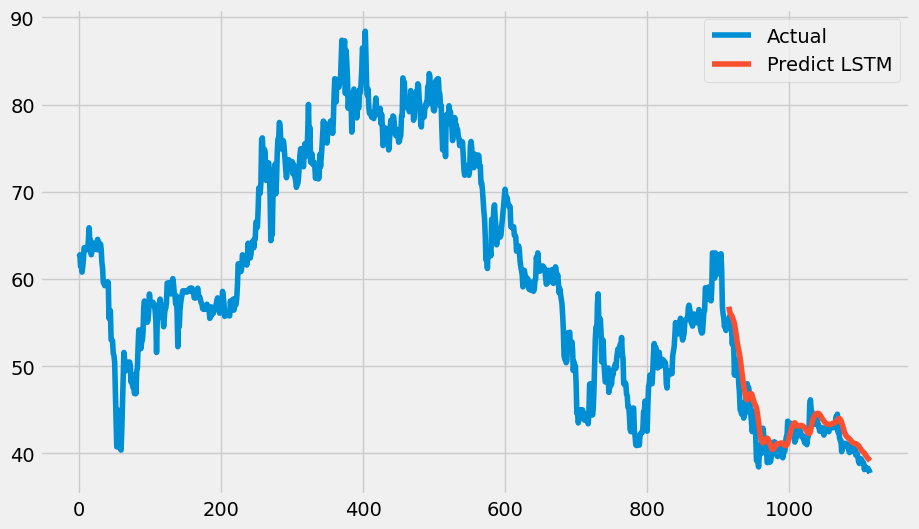

In [ ]:
actual = df[['close']]
pred_lstm = df[['close']].iloc[train_len:, :]
pred_lstm[['Predict LSTM']] = y_pred_lstm
plt.figure(figsize=(10, 6))
plt.plot(actual, label='Actual')
plt.plot(pred_lstm[['Predict LSTM']], label='Predict LSTM')
plt.legend()
plt.show()

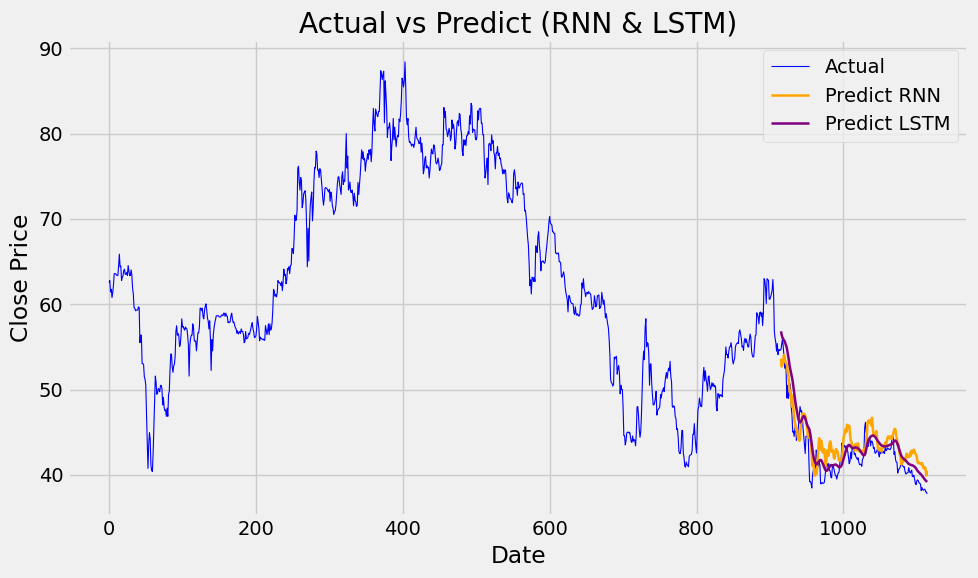

In [ ]:
import matplotlib.pyplot as plt

# Tạo figure
plt.figure(figsize=(10, 6))  # Kích thước biểu đồ

# Vẽ đường Actual
plt.plot(actual, label='Actual', color='blue', linewidth=0.8)

# Vẽ đường Predict RNN
plt.plot(pred_rnn['Predict RNN'], label='Predict RNN', color='orange', linewidth=1.8)

# Vẽ đường Predict LSTM
plt.plot(pred_lstm['Predict LSTM'], label='Predict LSTM', color='purple', linewidth=1.8)

# Thiết lập tiêu đề và nhãn
plt.title('Actual vs Predict (RNN & LSTM)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()


In [ ]:
data_10= df[['close']]
data_10.head()

,close
0,62.56
1,62.78
2,61.45
3,61.75
4,60.79


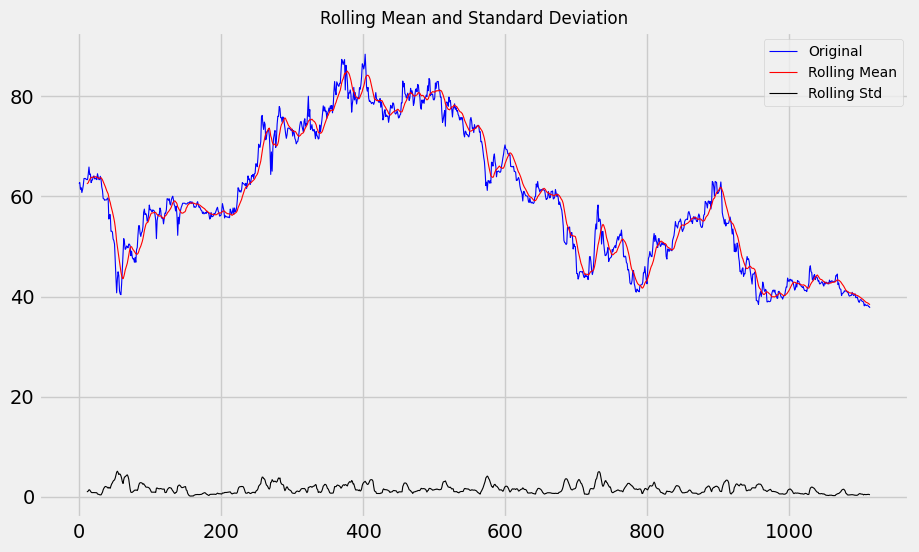

Results of Dickey-Fuller test
Test Statistics                  -1.090799
p-value                           0.718727
No. of lags used                  0.000000
Number of observations used    1114.000000
critical value (1%)              -3.436234
critical value (5%)              -2.864138
critical value (10%)             -2.568153
dtype: float64


In [ ]:
# Test for stationarity with thinner lines and smaller fonts
def test_stationarity(timeseries):
    # Determining rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics with thinner lines
    plt.figure(figsize=(10, 6))  # Adjust figure size if needed
    plt.plot(timeseries, color='blue', label='Original', linewidth=0.8)  # Thin blue line
    plt.plot(rolmean, color='red', label='Rolling Mean', linewidth=0.8)  # Thin red line
    plt.plot(rolstd, color='black', label='Rolling Std', linewidth=0.8)  # Thin black line
    plt.legend(loc='best', fontsize=10)  # Smaller font for legend
    plt.title('Rolling Mean and Standard Deviation', fontsize=12)  # Smaller title
    plt.show(block=False)

    # Print results of Dickey-Fuller test
    print("Results of Dickey-Fuller test")
    adft = adfuller(timeseries, autolag='AIC')
    output = pd.Series(adft[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['critical value (%s)' % key] = values
    print(output)

test_stationarity(data_10)


<Figure size 1000x600 with 0 Axes>

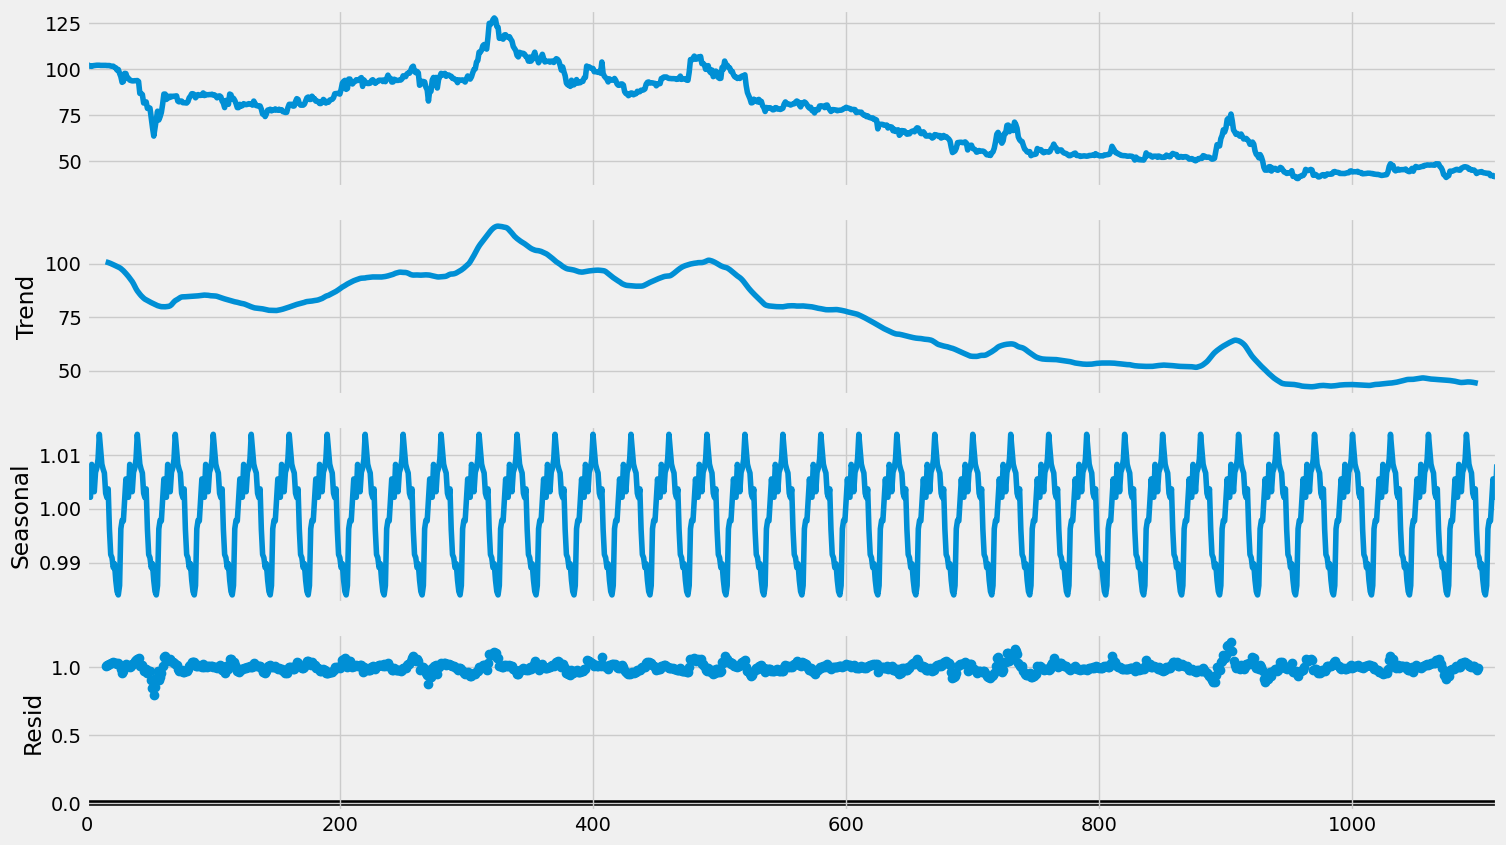

In [ ]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(data_10, model='multiplicative', period=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)
plt.show()

In [ ]:
# Differencing để loại bỏ xu hướng
df_differenced = data_10.diff(periods=1)  # Lấy sai phân bậc 1 (first differencing)
df_differenced.dropna(inplace=True)      # Loại bỏ các giá trị NaN sau khi lấy sai phân




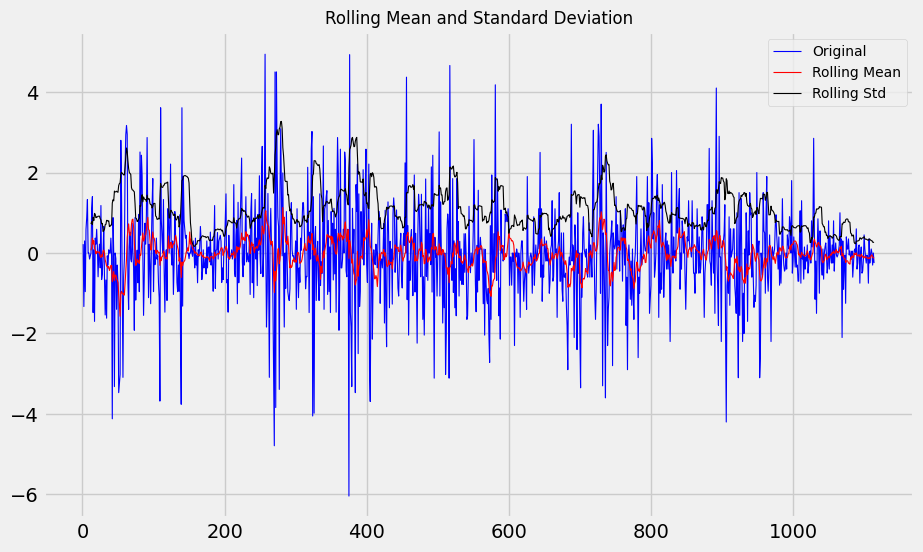

Results of Dickey-Fuller test
Test Statistics                 -33.113223
p-value                           0.000000
No. of lags used                  0.000000
Number of observations used    1113.000000
critical value (1%)              -3.436239
critical value (5%)              -2.864140
critical value (10%)             -2.568154
dtype: float64


In [ ]:
test_stationarity(df_differenced)


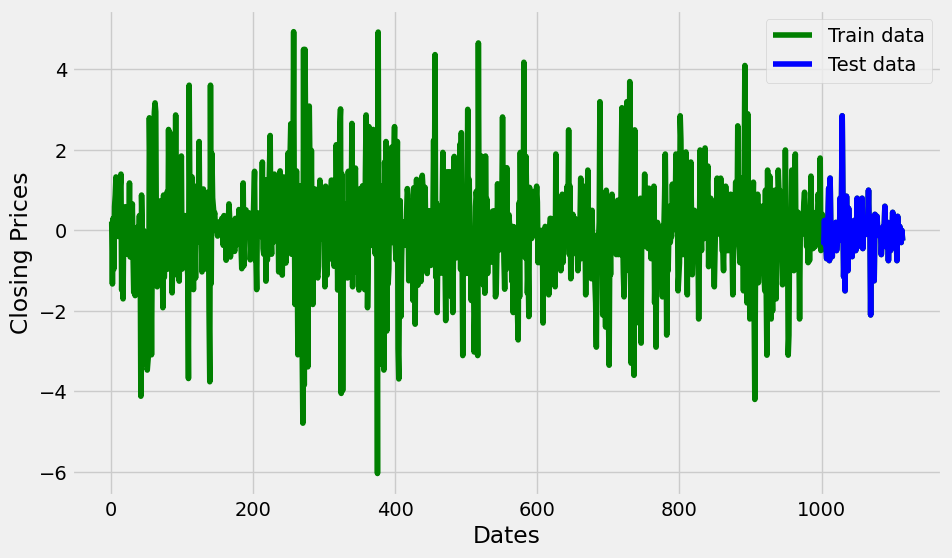

In [ ]:
#split data into train and training set
train_data, test_data = df_differenced[3:int(len(df_differenced)*0.9)], df_differenced[int(len(df_differenced)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_differenced, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()


Best model:  ARIMA(3,0,2)(0,0,0)[0]          
Total fit time: 17.101 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  999
Model:               SARIMAX(3, 0, 2)   Log Likelihood               -1647.572
Date:                Fri, 10 Jan 2025   AIC                           3307.144
Time:                        07:36:38   BIC                           3336.585
Sample:                             0   HQIC                          3318.334
                                - 999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8280      0.044    -18.636      0.000      -0.915      -0.741
ar.L2         -0.9222      0.044    -20.761      0.00

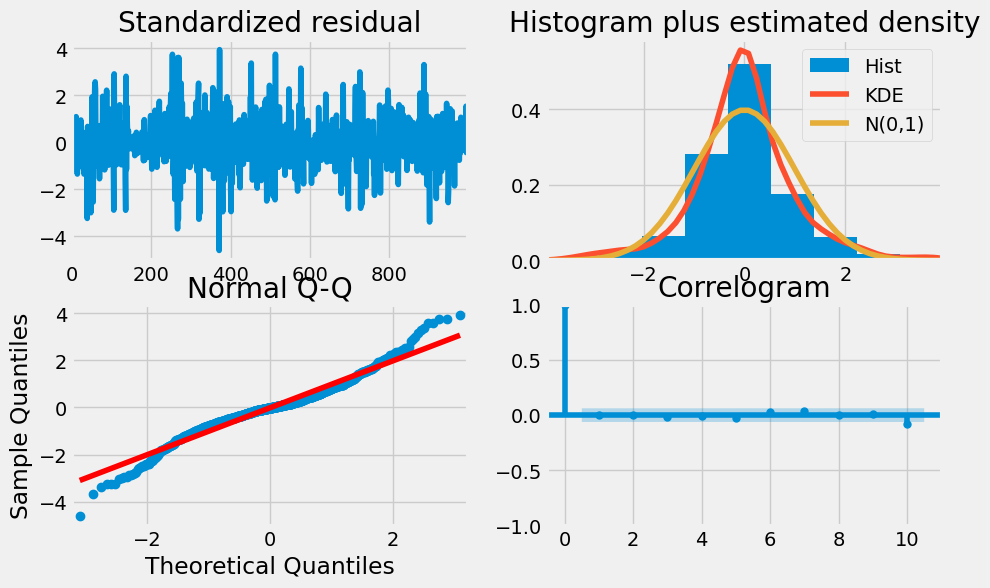

In [ ]:
model_autoARIMA = auto_arima(
    train_data,
    start_p=0, start_q=0, start_d=0,  # Bắt đầu từ giá trị nhỏ nhất
    max_p=10, max_q=10, max_d=5,     # Tăng giới hạn tìm kiếm
    test='adf',                      # Sử dụng kiểm định Dickey-Fuller để tìm 'd'
    m=1,                             # Không có yếu tố thời vụ (m=1)
    seasonal=False,                  # Không xem xét tính thời vụ
    trace=True,                      # Hiển thị thông tin quá trình tìm kiếm
    error_action='ignore',           # Bỏ qua lỗi khi thử nghiệm tham số
    suppress_warnings=True,          # Tắt cảnh báo không cần thiết
    stepwise=False,                  # Tìm kiếm toàn diện (brute-force)
    n_jobs=-1                        # Sử dụng đa luồng để tăng tốc
)

print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(10,6))
plt.show()

In [ ]:
# Xây dựng mô hình
model_Arima = ARIMA(train_data, order=(3,0,2))
# Loại bỏ tham số disp=-1.
fitted = model_Arima.fit()
print(fitted.summary())

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.


                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                  999
Model:                 ARIMA(3, 0, 2)   Log Likelihood               -1647.467
Date:                Fri, 10 Jan 2025   AIC                           3308.933
Time:                        07:37:04   BIC                           3343.280
Sample:                             0   HQIC                          3321.988
                                - 999                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0182      0.040     -0.453      0.650      -0.097       0.061
ar.L1         -0.8277      0.045    -18.482      0.000      -0.915      -0.740
ar.L2         -0.9219      0.045    -20.610      0.0

In [ ]:
# Dự báo đã được sửa
forecast_result = fitted.get_forecast(steps=len(df_differenced) - int(len(df_differenced)*0.9)) # số bước dự báo là 321
forecast_values = forecast_result.predicted_mean # lấy ra mảng numpy chứa các giá trị dự báo
conf = forecast_result.conf_int(alpha=0.05)  # khoảng tin cậy 95%

print(forecast_values)
print(conf)

999     0.100431
1000   -0.210704
1001    0.029669
1002    0.115998
1003   -0.167488
          ...   
1106   -0.018280
1107   -0.018623
1108   -0.017795
1109   -0.018145
1110   -0.018608
Name: predicted_mean, Length: 112, dtype: float64
      lower close  upper close
999     -2.366588     2.567450
1000    -2.677939     2.256532
1001    -2.437567     2.496905
1002    -2.353570     2.585565
1003    -2.638562     2.303585
...           ...          ...
1106    -2.499757     2.463198
1107    -2.500101     2.462854
1108    -2.499273     2.463683
1109    -2.499622     2.463333
1110    -2.500086     2.462869

[112 rows x 2 columns]


No supported index is available. Prediction results will be given with an integer index beginning at `start`.


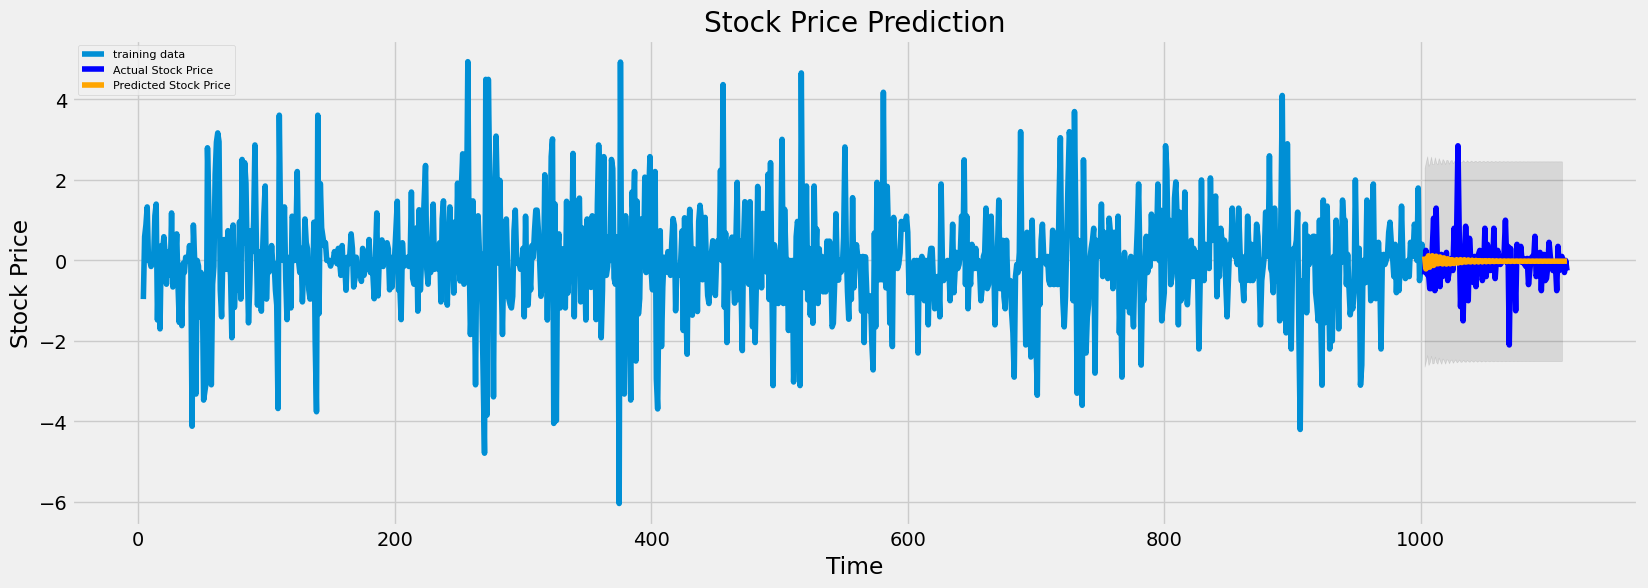

In [ ]:

# Lấy các cột khoảng tin cậy
conf_lower = conf.iloc[:, 0]
conf_upper = conf.iloc[:, 1]
# Đảm bảo giá trị dự báo là một mảng numpy.
fc = forecast_values.to_numpy()
# Tạo series pandas
fc_series = pd.Series(fc, index=test_data.index)
#thay đổi `conf[:,0]` và `conf[:,1]` để sử dụng iloc
lower_series = pd.Series(conf_lower, index=test_data.index)
upper_series = pd.Series(conf_upper, index=test_data.index)
# Vẽ đồ thị
plt.figure(figsize=(18,6), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title( 'Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
# Calculate MAE
mae = mean_absolute_error(test_data, fc_series)
print(f'MAE: {mae}')
# Calculate MAPE
mape = mean_absolute_percentage_error(test_data, fc_series)
print(f'MAPE: {mape}')
# Calculate RMSE
rmse = math.sqrt(mean_squared_error(test_data, fc_series))
print(f'RMSE: {rmse}')

MAE: 0.38195097460776406
MAPE: 8495016397677.586
RMSE: 0.5749031797226808


In [ ]:
df_1= stock_data.quote.history(start='2024-05-01', end='2024-06-21', interval='1D')
data_10= df_1[['close']]
data_10

,close
0,41.15
1,41.10
2,41.15
3,41.05
4,40.90
5,40.95
6,40.35
7,40.10
8,40.15
9,40.25


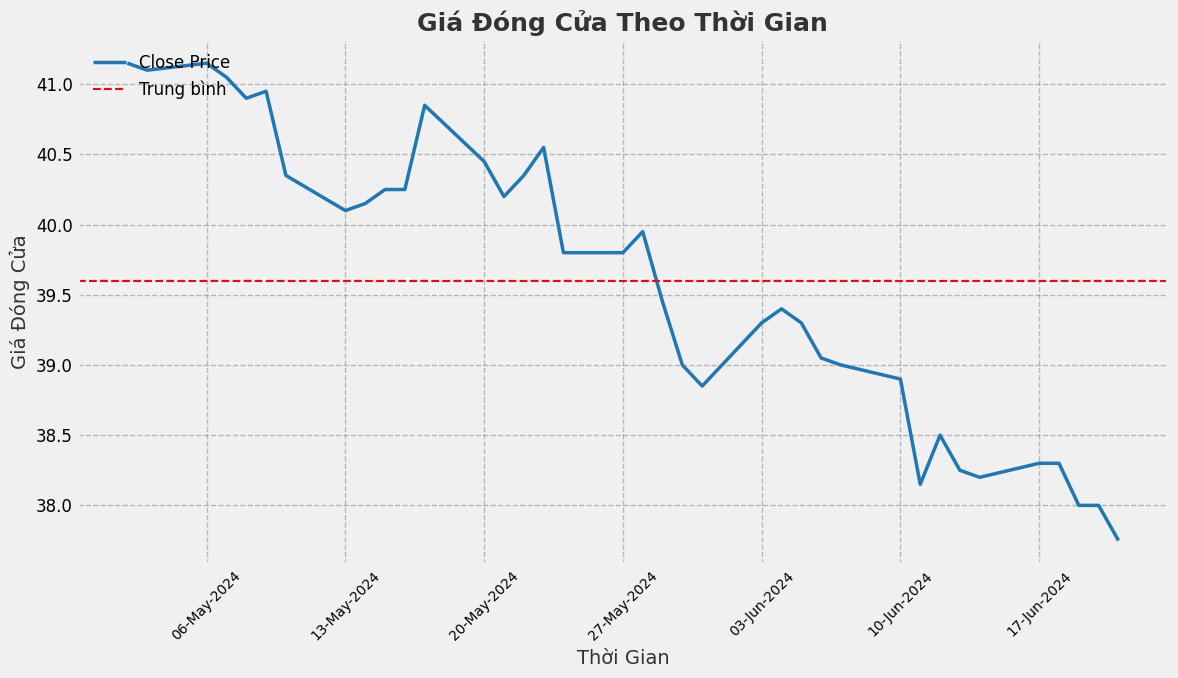

In [ ]:
import matplotlib.dates as mdates

# Tạo biểu đồ
plt.figure(figsize=(12, 7))  # Kích thước biểu đồ
plt.plot(df_1['time'], df_1['close'], label='Close Price', color='#1f77b4', linewidth=2.5)

# Tùy chỉnh trục x hiển thị ngày
if df_1['time'].dtype.name == 'datetime64[ns]':  # Nếu cột 'time' là dạng thời gian
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))  # Hiển thị 7 ngày 1 nhãn
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))  # Hiển thị ngày, tháng, năm
    plt.xticks(rotation=45, fontsize=10)  # Xoay nhãn 45 độ, giảm kích thước font

# Tùy chỉnh trục y
plt.yticks(fontsize=12)
plt.ylabel('Giá Đóng Cửa', fontsize=14, color='#333')

# Tùy chỉnh biểu đồ
plt.title('Giá Đóng Cửa Theo Thời Gian', fontsize=18, color='#333', fontweight='bold')
plt.xlabel('Thời Gian', fontsize=14, color='#333')
plt.grid(True, linestyle='--', alpha=0.5, color='gray')
plt.axhline(y=df_1['close'].mean(), color='red', linestyle='--', linewidth=1.5, label='Trung bình')  # Đường trung bình
plt.legend(fontsize=12, loc='upper left', frameon=False)

# Chỉnh bố cục
plt.tight_layout()

# Hiển thị biểu đồ
plt.show()


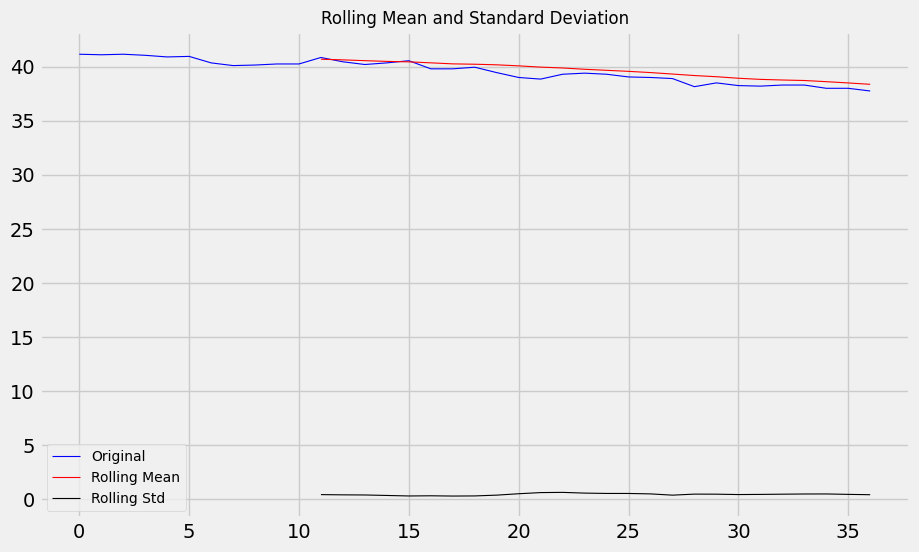

Results of Dickey-Fuller test
Test Statistics                -0.564926
p-value                         0.878712
No. of lags used                0.000000
Number of observations used    36.000000
critical value (1%)            -3.626652
critical value (5%)            -2.945951
critical value (10%)           -2.611671
dtype: float64


In [ ]:
test_stationarity(data_10)


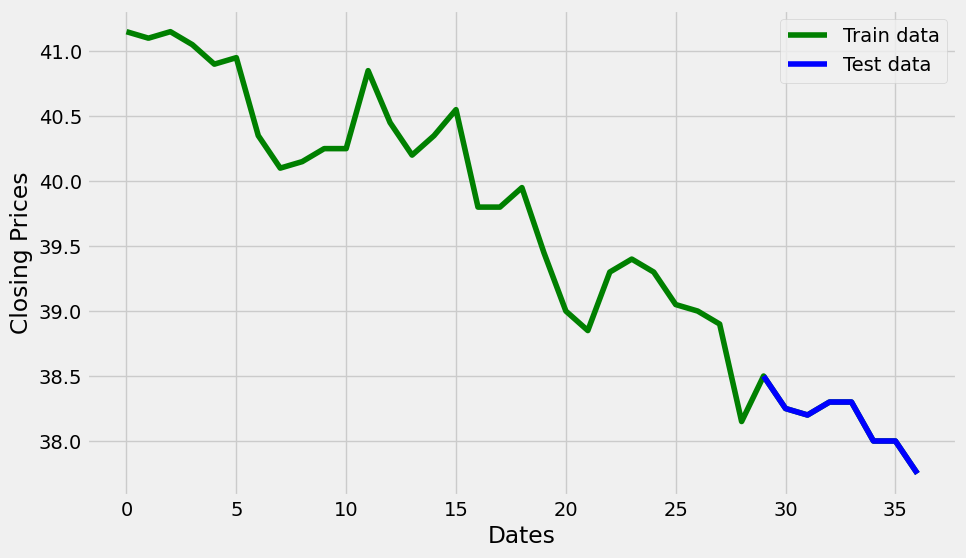

In [ ]:
#split data into train and training set
train_data, test_data = data_10[3:int(len(data_10)*0.8)], data_10[int(len(data_10)*0.8):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(data_10, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [ ]:
model_autoARIMA_1= auto_arima(
    train_data,
    start_p=0, start_q=0, start_d=0,  # Bắt đầu từ giá trị nhỏ nhất
    max_p=10, max_q=10, max_d=5,     # Tăng giới hạn tìm kiếm
    test='adf',                      # Sử dụng kiểm định Dickey-Fuller để tìm 'd'
    m=1,                             # Không có yếu tố thời vụ (m=1)
    seasonal=False,                  # Không xem xét tính thời vụ
    trace=True,                      # Hiển thị thông tin quá trình tìm kiếm
    error_action='ignore',           # Bỏ qua lỗi khi thử nghiệm tham số
    suppress_warnings=True,          # Tắt cảnh báo không cần thiết
    stepwise=False,                  # Tìm kiếm toàn diện (brute-force)
    n_jobs=-1                        # Sử dụng đa luồng để tăng tốc
)

print(model_autoARIMA_1.summary())



Best model:  ARIMA(0,2,3)(0,0,0)[0] intercept
Total fit time: 2.448 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   26
Model:               SARIMAX(0, 2, 3)   Log Likelihood                  -7.809
Date:                Wed, 08 Jan 2025   AIC                             25.619
Time:                        06:15:55   BIC                             31.509
Sample:                             0   HQIC                            27.182
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0042      0.005     -0.901      0.368      -0.013       0.005
ma.L1         -1.3822     12.292     -0.112      0.910

In [ ]:
# Xây dựng mô hình
model_Arima_1 = ARIMA(train_data, order=(0,2,3))
# Loại bỏ tham số disp=-1.
fitted = model_Arima_1.fit()
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   26
Model:                 ARIMA(0, 2, 3)   Log Likelihood                  -8.383
Date:                Wed, 08 Jan 2025   AIC                             24.767
Time:                        06:16:03   BIC                             29.479
Sample:                             0   HQIC                            26.017
                                 - 26                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.1304     11.096     -0.102      0.919     -22.877      20.616
ma.L2         -0.2068      1.516     -0.136      0.892      -3.179       2.765
ma.L3          0.3394      3.707      0.092      0.9

In [ ]:
# Dự báo đã được sửa
forecast_result = fitted.get_forecast(steps=len(data_10) - int(len(data_10)*0.8)) # số bước dự báo là 321
forecast_values = forecast_result.predicted_mean # lấy ra mảng numpy chứa các giá trị dự báo
conf = forecast_result.conf_int(alpha=0.00001)  # khoảng tin cậy 95%

print(forecast_values)
print(conf)

29    38.131953
30    38.238755
31    38.136273
32    38.033791
33    37.931309
34    37.828826
35    37.726344
36    37.623862
Name: predicted_mean, dtype: float64
    lower close  upper close
29    36.725564    39.538342
30    36.338916    40.138594
31    36.056954    40.215592
32    35.778680    40.288901
33    35.503290    40.359327
34    35.230204    40.427449
35    34.958992    40.493696
36    34.689329    40.558395


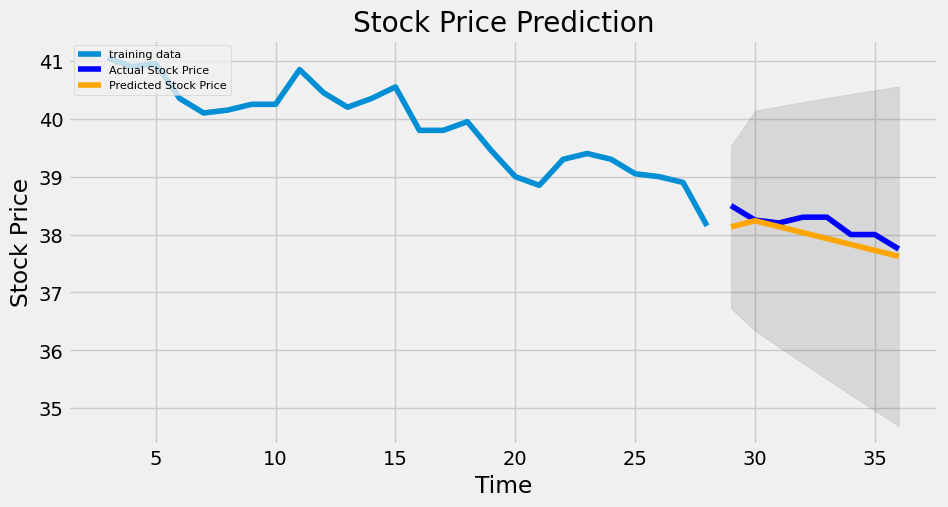

In [ ]:

# Lấy các cột khoảng tin cậy
conf_lower = conf.iloc[:, 0]
conf_upper = conf.iloc[:, 1]
# Đảm bảo giá trị dự báo là một mảng numpy.
fc = forecast_values.to_numpy()
# Tạo series pandas
fc_series = pd.Series(fc, index=test_data.index)
#thay đổi `conf[:,0]` và `conf[:,1]` để sử dụng iloc
lower_series = pd.Series(conf_lower, index=test_data.index)
upper_series = pd.Series(conf_upper, index=test_data.index)
# Vẽ đồ thị
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title( 'Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
print(train_data.tail())  # Xem dữ liệu cuối của train
print(test_data.head())  # Xem dữ liệu đầu của test


    close
24  39.30
25  39.05
26  39.00
27  38.90
28  38.15
    close
29  38.50
30  38.25
31  38.20
32  38.30
33  38.30


In [ ]:
print(train_data.index)
print(test_data.index)
print(forecast_values.index)


RangeIndex(start=3, stop=29, step=1)
RangeIndex(start=29, stop=37, step=1)
RangeIndex(start=29, stop=37, step=1)
